In [1]:
import pandas as pd

### Get data

In [2]:
product = pd.read_excel('product_data.xlsx')
sales = pd.read_excel('sale_data.xlsx')

product.head()

,product_id,product_name
0,1,Teal Everyday Wireless Speaker
1,2,Pink Everyday Wireless Speaker
2,3,FabFitFun Summer 2015 Box
3,4,FabFitFun Spring 2015 Box
4,5,Daniel Stone COCO Candle


In [3]:
sales.head()

,member_id,product_id,quantity
0,806,4115,1
1,772,4115,1
2,772,4116,1
3,772,4117,1
4,772,4119,1


In [4]:
# get product names in sales data

sales.product_id.nunique()
sales = pd.merge(sales, product, on='product_id', how='inner')

In [5]:
product.product_id.nunique() # not all the products were sold

4140

### Percentage of products sold

In [6]:
unique_products_sold = sales.product_id.nunique() # from sales
unique_products = product.product_id.nunique()  # from products

percent_products_sold = (unique_products_sold/unique_products)*100

print("Out of {} products, {} were sold, so around {} percent of products sold".
      format(unique_products, unique_products_sold, percent_products_sold))

Out of 4140 products, 266 were sold, so around 6.42512077294686 percent of products sold


### Top products sold by quantity

In [7]:
products_total_sales = sales.groupby(['product_id','product_name'])['quantity'].sum().reset_index()
products_total_sales.sort_values(by='quantity', ascending=False)[:10]

,product_id,product_name,quantity
214,4067,PEEK Beauty Double Take Palette,154
206,4055,Murad Pore Extractor Pomegranate Mask,152
247,4110,Poo~Pourri Original Citrus Spray,110
73,3429,Luxie 3 Piece Sculpted Face Set,100
175,4010,AHAVA Body Lotion Trio,93
171,3784,Mystery Bundle,74
90,3581,Blaq Teeth Whitening Powder,73
178,4015,Billion Dollar Brows Clear Brow Gel,70
151,3712,Soleil Cordless Flat Iron,68
176,4011,AHAVA Dead Sea Salt in Eucalyptus,68


Text(0, 0.5, 'Products')

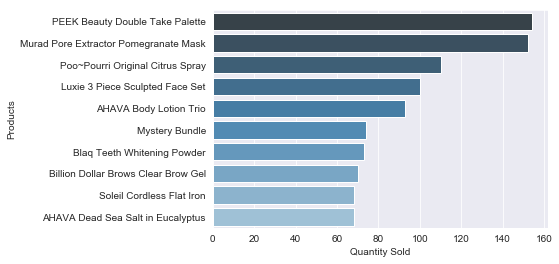

In [9]:
top_product_list = products_total_sales.sort_values(by='quantity', ascending=False).product_name.iloc[:10].tolist()
top_products = products_total_sales.sort_values(by='quantity', ascending=False).iloc[:10]

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
ax=sns.barplot(x='quantity', y='product_name', data = top_products, palette="Blues_d");
ax.set_xlabel('Quantity Sold')
ax.set_ylabel('Products')

### Bottom products by quantity sold

Text(0, 0.5, 'Products')

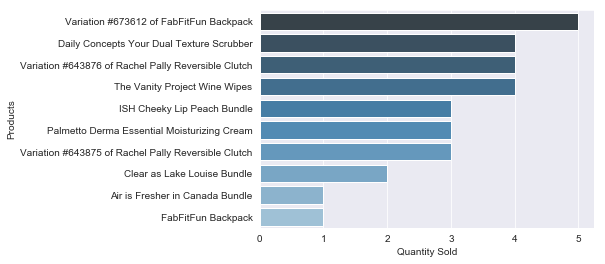

In [10]:
bottom_products = products_total_sales.sort_values(by='quantity').iloc[:10]
bottom_products = bottom_products.sort_values(by='quantity', ascending=False)

ax=sns.barplot(x='quantity', y='product_name', data = bottom_products, palette="Blues_d");
ax.set_xlabel('Quantity Sold')
ax.set_ylabel('Products')

### Distrubution of users by products bought

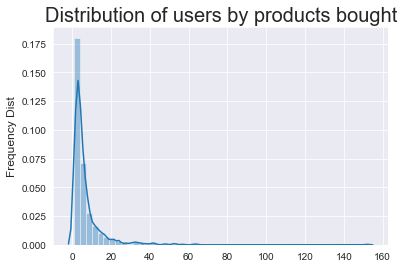

In [14]:
products_bought_by_users = sales.groupby(['member_id'])['quantity'].sum().reset_index()
products_bought_by_users.sort_values(by='quantity', ascending=False)

quantity_by_users = products_bought_by_users.groupby(['quantity'])['member_id'].count().reset_index()
quantity_by_users

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
g = sns.distplot(products_bought_by_users.quantity, hist=True)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Frequency Dist", fontsize=12)
g.set_title("Distribution of users by products bought", fontsize=20)
plt.show()


Text(0, 0.5, 'Percentage of users')

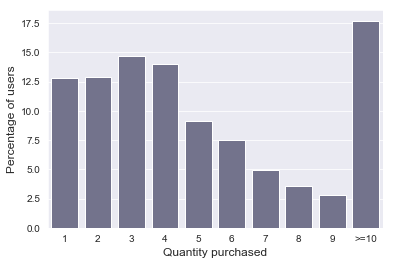

In [15]:
# Divide users into quantity buckets

quantity_by_users.loc[quantity_by_users.quantity ==1, 'label'] = '1'
quantity_by_users.loc[quantity_by_users.quantity ==2, 'label'] = '2'
quantity_by_users.loc[quantity_by_users.quantity ==3, 'label'] = '3'
quantity_by_users.loc[quantity_by_users.quantity ==4, 'label'] = '4'
quantity_by_users.loc[quantity_by_users.quantity ==5, 'label'] = '5'
quantity_by_users.loc[quantity_by_users.quantity ==6, 'label'] = '6'
quantity_by_users.loc[quantity_by_users.quantity ==7, 'label'] = '7'
quantity_by_users.loc[quantity_by_users.quantity ==8, 'label'] = '8'
quantity_by_users.loc[quantity_by_users.quantity ==9, 'label'] = '9'
quantity_by_users.loc[quantity_by_users.quantity >=10, 'label'] = '>=10'

quantity_users = quantity_by_users.groupby(['label'])['member_id'].sum().reset_index()
quantity_users['percent'] = (quantity_users['member_id']/sum(quantity_users['member_id']))*100


g=sns.barplot(x='label', y='percent', data=quantity_users, color='b', saturation=0.1)
g.set_xlabel("Quantity purchased", fontsize=12)
g.set_ylabel("Percentage of users", fontsize=12)

### Association rules mining

Text(33.99999999999997, 0.5, 'People who bought this')

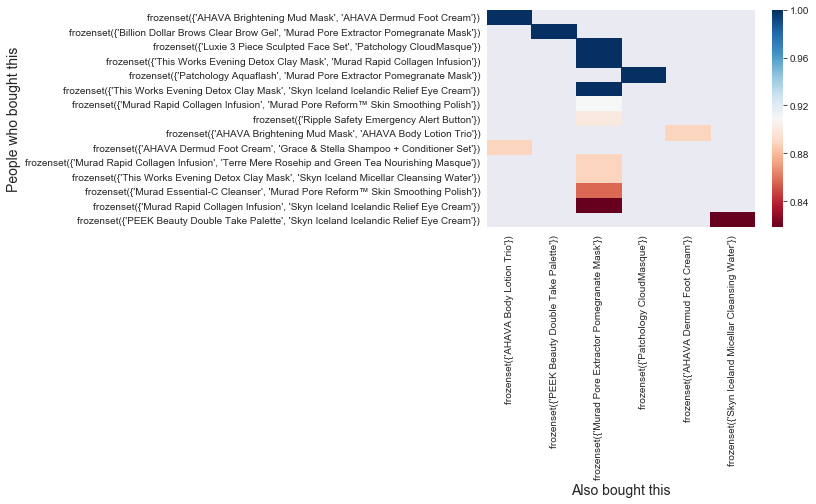

In [24]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Market Basket Analysis
# Given there is no order number, date, time etc to understand if users bought these items together or not, 
# but we can assume that users bought products together, so if user 1 has bought product1, product4, and product5, we'll
# assume it was part of one order

basket = (sales
          .groupby(['member_id', 'product_name'])['quantity']
          .sum().unstack().reset_index().fillna(0).set_index('member_id'))



def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
#basket_sets.drop('POSTAGE', inplace=True, axis=1)

frequent_itemsets = apriori(basket_sets, min_support=0.008, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift")

rules.sort_values(by='confidence', ascending=False)
rules_of_interest = rules[(rules.confidence > 0.80)].sort_values(by='confidence', ascending=False)

top_rules = rules_of_interest[['antecedents', 'consequents', 'confidence']].pivot('antecedents', 'consequents', 'confidence')
g=sns.heatmap(top_rules, cmap="RdBu")
g.set_xlabel("Also bought this", fontsize=14)
g.set_ylabel("People who bought this", fontsize=14)

In [25]:
basket['Murad Pore Reform™ Skin Smoothing Polish'].sum()

basket['Murad Rapid Collagen Infusion'].sum()

basket['Murad Pore Extractor Pomegranate Mask'].sum()

basket['Patchology CloudMasque'].sum()

rules_of_interest['antecedents']
basket['AHAVA Brightening Mud Mask'].sum()

31.0

### Exploring bi grams/ngrams

In [26]:
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

def convert_to_words( raw_search_query ):
    # Function to convert a raw search query to a string of words
    # The input is a single string (a raw search query), and
    # the output is a single string (a preprocessed search query)
    #
    # 1. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", raw_search_query)
    #
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))
    #
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    #
    # 5. Join the words back into one string separated by space,
    # and return the result. The reason we join the words again
    # is to remove the search queries that are duplicated
    # return( " ".join(meaningful_words ))
    return (meaningful_words)


    
corpus = []
num_search_query = len(product['product_name'])
for i in range(0, num_search_query):
    temp = convert_to_words(product['product_name'][i])
    #sales['product_name'] unique_products_sold
    corpus = corpus + temp

from collections import Counter
from itertools import islice
Counter(zip(corpus, islice(corpus, 1, None)))

Counter({('teal', 'everyday'): 2,
         ('everyday', 'wireless'): 9,
         ('wireless', 'speaker'): 9,
         ('speaker', 'pink'): 2,
         ('pink', 'everyday'): 3,
         ('speaker', 'fabfitfun'): 2,
         ('fabfitfun', 'summer'): 46,
         ('summer', 'box'): 51,
         ('box', 'fabfitfun'): 19,
         ('fabfitfun', 'spring'): 23,
         ('spring', 'box'): 29,
         ('box', 'daniel'): 1,
         ('daniel', 'stone'): 14,
         ('stone', 'coco'): 10,
         ('coco', 'candle'): 10,
         ('candle', 'gramr'): 1,
         ('gramr', 'gratitude'): 2,
         ('gratitude', 'thank'): 2,
         ('thank', 'card'): 3,
         ('card', 'set'): 4,
         ('set', 'lather'): 1,
         ('lather', 'aha'): 2,
         ('aha', 'hand'): 2,
         ('hand', 'creme'): 2,
         ('creme', 'evening'): 2,
         ('evening', 'primrose'): 3,
         ('primrose', 'debra'): 1,
         ('debra', 'shepard'): 2,
         ('shepard', 'earrings'): 2,
         ('earrin